## Reproduction of RQ2-3 (Figure 4, Table 6)

This notebook reproduces the values in Table 6 and Figure 4 (selection and ranking results presented in RQ2-3). 

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from evaluate_util import *
plt.style.use('../style/smstyle-formal.mplstyle')

In [2]:
ranking_result_path = {
    'Codex': '../data/ranking_results/ranking_features_d4j_Codex_n10.csv',
    'GPT-3.5-0301': '../data/ranking_results/ranking_features_d4j_GPT-3.5-0301_n10.csv',
    'GPT-3.5-0613': '../data/ranking_results/ranking_features_d4j_GPT-3.5-0613_n10.csv',
    'StarCoder-15B': '../data/ranking_results/ranking_features_d4j_StarCoder_n10.csv',
    # 'StarCoderPlus': '../data/ranking_results/ranking_features_d4j_StarCoderPlus_n10.csv',
    # 'StarCoderBase-15B': '../data/ranking_results/ranking_features_d4j_StarCoderBase_n10.csv',
    'Incoder-6B': '../data/ranking_results/ranking_features_d4j_Incoder-6B_n10.csv',
    'CodeGen2-16B': '../data/ranking_results/ranking_features_d4j_CodeGen2-16B_n10.csv',
    'Bloom': '../data/ranking_results/ranking_features_d4j_Bloom_n10.csv',
    # 'BloomZ': '../data/ranking_results/ranking_features_d4j_BloomZ_n10.csv',
}

ranking_feature_dfs = {}
max_dfs = {}

for model, result_path in ranking_result_path.items():
    with open(result_path) as f:
        ranking_feature_dfs[model] = pd.read_csv(f)
        max_dfs[model] = ranking_feature_dfs[model].groupby('bug_id').max()

### Figure 4: selection accuracy for different thresholds

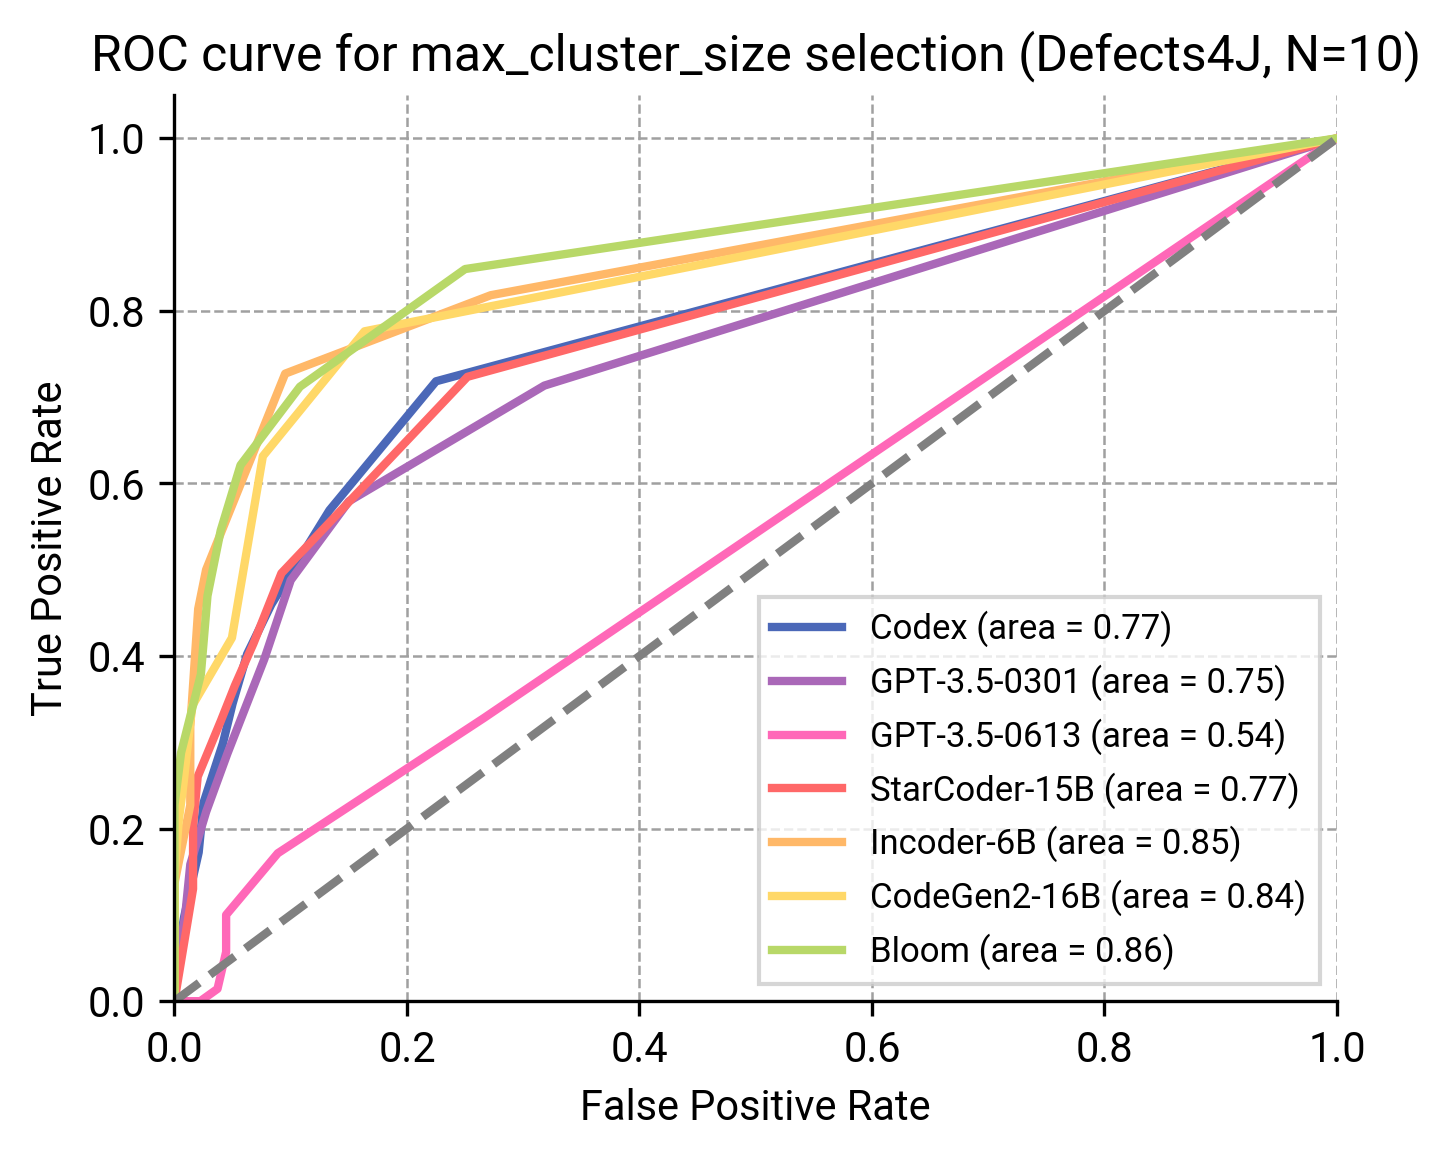

In [3]:
plt.figure(figsize=(5,4))

colors = ['#4B68B8', '#AA68B8', '#FF68B8', '#FF6868', '#FFB868', '#FFD868', '#B8D868', '#68D868', '#68D8B8', '#68B8D8']

for i, (model, max_df) in enumerate(max_dfs.items()):
    fpr, tpr, _ = roc_curve(max_df.success.tolist(), list(map(lambda x: x/10, max_df.clus_size_output_fib.tolist())))
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color=colors[i],
        lw=lw,
        label=f"{model} (area = %0.2f)" % roc_auc,
    )


plt.plot([0, 1], [0, 1], color="grey", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for max_cluster_size selection (Defects4J, N=10)")
plt.legend(loc="lower right")
plt.savefig('./figures/roc_curve_comparison_d4j_n10.pdf', bbox_inches='tight')

plt.show()

['Codex', 'GPT-3.5-0301', 'GPT-3.5-0613', 'StarCoder-15B', 'Incoder-6B', 'CodeGen2-16B', 'Bloom']


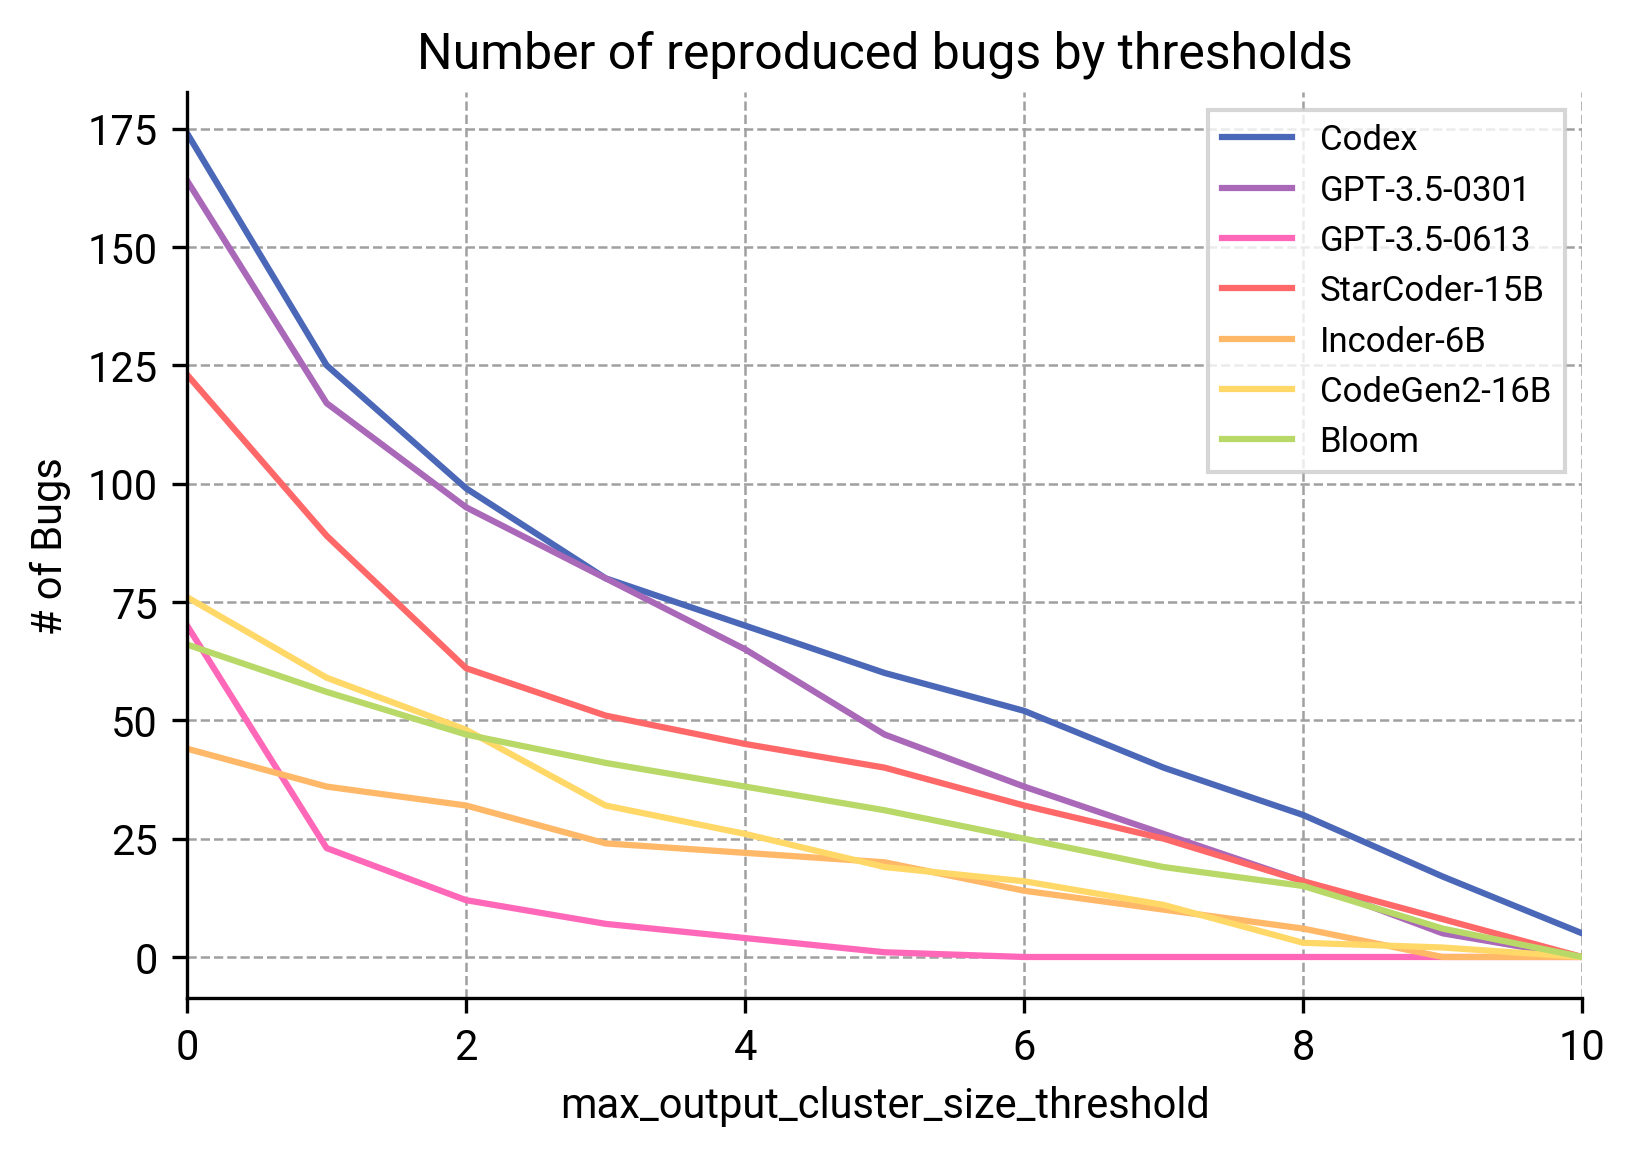

In [4]:
rows = []

thresholds = range(0, 11)

for th in thresholds:
    th_result = {
        'threshold': th,
        # 'precision': precision,
        # 'num_bugs': len(selected_df),
        # 'num_success_bugs': len(selected_df[selected_df.success])
    }

    for model, max_df in max_dfs.items():
        selected_df = max_df[max_df.clus_size_output_fib > th].reset_index()
        th_result[f'num_reproduced_{model}'] = len(selected_df[selected_df.success])

    rows.append(th_result)

stat_df = pd.DataFrame(rows)
fig, ax1 = plt.subplots(figsize=(6,4))
# ax2 = ax1.twinx()
# p1 = sns.lineplot(data=stat_df['num_success_bugs'], color='darkorange', ax=ax1, legend='brief')

colors = ['#4B68B8', '#AA68B8', '#FF68B8', '#FF6868', '#FFB868', '#FFD868', '#B8D868', '#68D868', '#68D8B8', '#68B8D8']

legend_names = []
handles = []
for i, col in enumerate([c for c in stat_df.columns if 'num_reproduced' in c]):
    legend_names.append(col.replace('num_reproduced_', ''))
    p = sns.lineplot(data=stat_df[col], color=colors[i], ax=ax1, legend='auto')
    handles.append(p.lines[i])
    # add legend

# p2 = sns.lineplot(data=stat_df['num_bugs'], color='darkorange', ax=ax1, linestyle='dashed')
# p3 = sns.lineplot(data=stat_df['precision'], color='#4B68B8', ax=ax2, legend='brief')

ax1.set_xlabel('max_output_cluster_size_threshold')
ax1.set_ylabel('# of Bugs')
# ax2.set_ylabel('Precision')
# p1.set_title("Threshold to Number of Has-BRT Bugs and Precision")
ax1.set_xlim(0,10)
# ax2.set_xlim(0,10)
ax1.set_title('Number of reproduced bugs by thresholds')
# ax1.legend(['# of reproduced bugs', '# of all bugs'], loc='upper left', bbox_to_anchor=(1.1, 0.9))
print(legend_names)
ax1.legend(handles, legend_names)
# ax2.legend(['Precision'], loc= 'upper right', bbox_to_anchor=(1.0, 0.7))
plt.savefig('./figures/thr_num_reproduced_bugs.pdf', bbox_inches='tight')
plt.show()

['Codex', 'GPT-3.5-0301', 'GPT-3.5-0613', 'StarCoder-15B', 'Incoder-6B', 'CodeGen2-16B', 'Bloom']


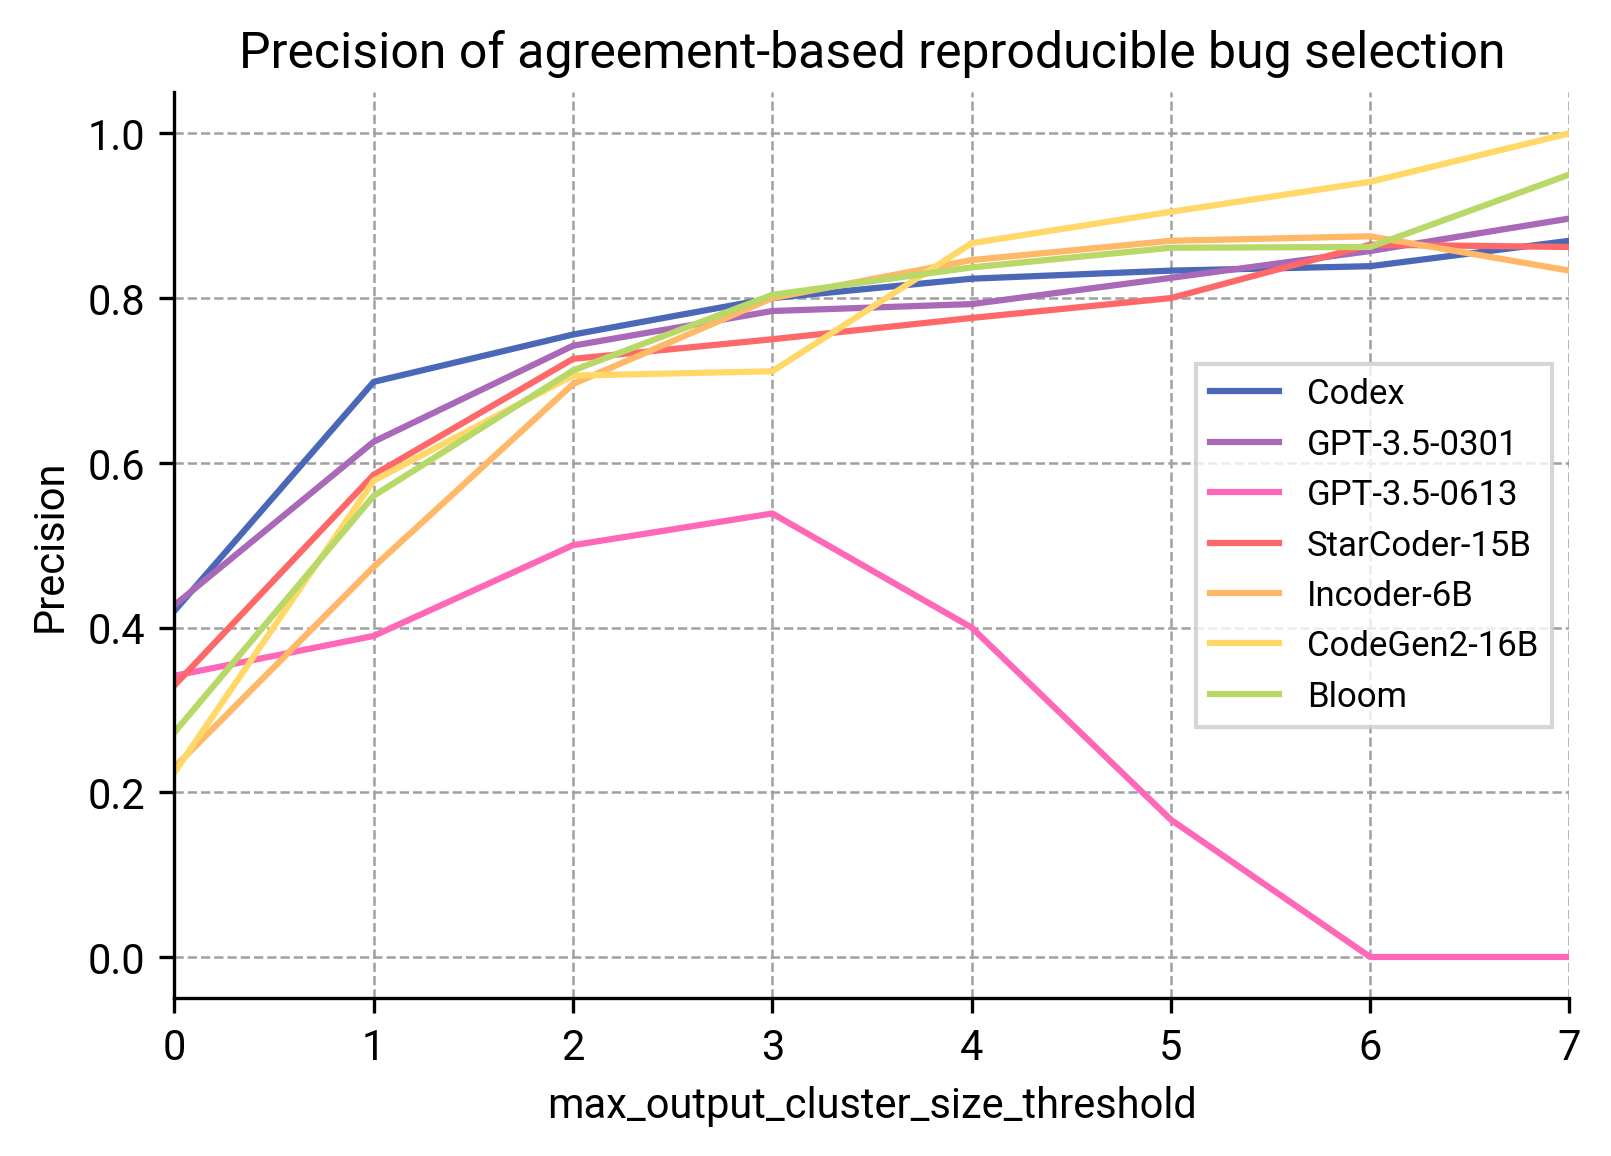

In [5]:
rows = []

thresholds = range(0, 8)

for th in thresholds:
    # precision = len(selected_df[selected_df.success]) / len(selected_df)
    th_result = {
        'threshold': th,
        # 'precision': precision,
        # 'num_bugs': len(selected_df),
        # 'num_success_bugs': len(selected_df[selected_df.success])
    }

    for model, max_df in max_dfs.items():
        selected_df = max_df[max_df.clus_size_output_fib > th].reset_index()
        if len(selected_df) == 0:
            continue
    
        # th_result[f'num_reproduced_{model}'] = len(selected_df[selected_df.success])
        th_result[f'precision_{model}'] = len(selected_df[selected_df.success])/len(selected_df)

    rows.append(th_result)

stat_df = pd.DataFrame(rows)
fig, ax1 = plt.subplots(figsize=(6,4))
# ax2 = ax1.twinx()
# p1 = sns.lineplot(data=stat_df['num_success_bugs'], color='darkorange', ax=ax1, legend='brief')

colors = ['#4B68B8', '#AA68B8', '#FF68B8', '#FF6868', '#FFB868', '#FFD868', '#B8D868', '#68D868', '#68D8B8', '#68B8D8']

legend_names = []
handles = []
for i, col in enumerate([c for c in stat_df.columns if 'precision' in c]):
    legend_names.append(col.replace('precision_', ''))
    p = sns.lineplot(data=stat_df[col], color=colors[i], ax=ax1, legend='auto')
    handles.append(p.lines[i])
    # add legend

# p2 = sns.lineplot(data=stat_df['num_bugs'], color='darkorange', ax=ax1, linestyle='dashed')
# p3 = sns.lineplot(data=stat_df['precision'], color='#4B68B8', ax=ax2, legend='brief')

ax1.set_xlabel('max_output_cluster_size_threshold')
ax1.set_ylabel('Precision')
# ax2.set_ylabel('Precision')
# p1.set_title("Threshold to Number of Has-BRT Bugs and Precision")
ax1.set_xlim(0,7)
# ax2.set_xlim(0,10)
ax1.set_title('Precision of agreement-based reproducible bug selection')
# ax1.legend(['# of reproduced bugs', '# of all bugs'], loc='upper left', bbox_to_anchor=(1.1, 0.9))
print(legend_names)
ax1.legend(handles, legend_names)
# ax2.legend(['Precision'], loc= 'upper right', bbox_to_anchor=(1.0, 0.7))
plt.savefig('./figures/thr_precision.pdf', bbox_inches='tight')
plt.show()

In [6]:
THR = 1
df = max_df[max_df.clus_size_output_fib <= THR]
selected_df = max_df[max_df.clus_size_output_fib > THR].reset_index()

print(f'[Threshold = {THR}]')
print("# precision: ", len(selected_df[selected_df.success]) / len(selected_df))
print("# recall: ", len(selected_df[selected_df.success]) / (len(selected_df[selected_df.success]) + len(df[df.success])))
print("# accuracy: ", (len(selected_df[selected_df.success]) + len(df[~df.success]))/ (len(max_df)))
print("Reduction rate: ", len(max_df), '=>', len(selected_df), ', ', str(round(len(selected_df)/len(max_df)*100, 2)) + '%')

[Threshold = 1]
# precision:  0.56
# recall:  0.8484848484848485
# accuracy:  0.7768595041322314
Reduction rate:  242 => 100 ,  41.32%


### Table 6: ranking result on selected data 
* max_output_clus_size threshold=1

#### Defects4J Ranking Result

In [7]:
models = list(ranking_result_path.keys())

result_df = pd.DataFrame()
for model in models:
    with open(f'../data/ranking_results/ranking_d4j_{model}_n10_selected_th1.csv') as f:
        rank_df = pd.read_csv(f)

    metrics = evaluate_ranking(rank_df)
    metrics['model'] = model
    # round to 2 decimal places
    for k, v in metrics.items():
        if k != 'model':
            metrics[k] = round(v, 2)

    result_df = pd.concat([result_df, pd.DataFrame([metrics])], ignore_index=True)

result = result_df[['model', 'acc@1', 'acc@3', 'acc@5', 'prec@1', 'prec@3', 'prec@5']].sort_values(by='acc@1', ascending=False)
    
display(result)
print(result.to_latex(index=False))

,model,acc@1,acc@3,acc@5,prec@1,prec@3,prec@5
0,Codex,107,122,123,0.60,0.68,0.69
1,GPT-3.5-0301,92,112,115,0.49,0.60,0.61
3,StarCoder-15B,70,83,89,0.46,0.55,0.59
5,CodeGen2-16B,48,56,57,0.47,0.55,0.56
6,Bloom,45,54,56,0.45,0.54,0.56
4,Incoder-6B,29,33,34,0.38,0.43,0.45
2,GPT-3.5-0613,18,22,23,0.31,0.37,0.39


\begin{tabular}{lrrrrrr}
\toprule
        model &  acc@1 &  acc@3 &  acc@5 &  prec@1 &  prec@3 &  prec@5 \\
\midrule
        Codex &    107 &    122 &    123 &    0.60 &    0.68 &    0.69 \\
 GPT-3.5-0301 &     92 &    112 &    115 &    0.49 &    0.60 &    0.61 \\
StarCoder-15B &     70 &     83 &     89 &    0.46 &    0.55 &    0.59 \\
 CodeGen2-16B &     48 &     56 &     57 &    0.47 &    0.55 &    0.56 \\
        Bloom &     45 &     54 &     56 &    0.45 &    0.54 &    0.56 \\
   Incoder-6B &     29 &     33 &     34 &    0.38 &    0.43 &    0.45 \\
 GPT-3.5-0613 &     18 &     22 &     23 &    0.31 &    0.37 &    0.39 \\
\bottomrule
\end{tabular}

